<a href="https://colab.research.google.com/github/Next-Sunshine/TFF0318/blob/master/UpAcc_ServerKeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 导包

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
#环境测试
#@test {"skip":true}
!pip install --quiet --upgrade tensorflow_federated
%load_ext tensorboard

     |████████████████████████████████| 430kB 1.9MB/s 
     |████████████████████████████████| 421.8MB 34kB/s 
     |████████████████████████████████| 2.8MB 59.0MB/s 
     |████████████████████████████████| 20.0MB 1.2MB/s 
     |████████████████████████████████| 102kB 15.3MB/s 
     |████████████████████████████████| 296kB 74.4MB/s 
     |████████████████████████████████| 2.2MB 68.4MB/s 
     |████████████████████████████████| 450kB 72.2MB/s 
     |████████████████████████████████| 3.9MB 62.6MB/s 
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [2]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt
import h5py
import random
import math
import gc

tf.compat.v1.enable_v2_behavior()

np.random.seed(0)

tff.federated_computation(lambda: 'Hello, world!')()

b'Hello, world!'

In [0]:
#装载数据集，实验使用EMNIST数据集
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()
#装载mnist数据集
mnist_train, mnist_test = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


### 加载EMNIST-digit数据集

In [0]:
#读取EMNIST数据集的Digit
# 引入必要的库函数:要把那四个gz文档上传上来
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.util.tf_export import tf_export
import gzip

# 读取本地gz文档，并转换为numpy矩阵的函数
def load_localData():
  #files = ['emnist-digits-train-labels-idx1-ubyte.gz', 'emnist-digits-train-images-idx3-ubyte.gz', 'emnist-digits-test-labels-idx1-ubyte.gz', 'emnist-digits-test-images-idx3-ubyte.gz']
  path = ['/content/drive/My Drive/Colab Notebooks/emnist-digits-train-labels-idx1-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-train-images-idx3-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-test-labels-idx1-ubyte.gz', 
        '/content/drive/My Drive/Colab Notebooks/emnist-digits-test-images-idx3-ubyte.gz']

  with gzip.open(path[0], 'rb') as lpath:
    y_train = np.frombuffer(lpath.read(), np.uint8, offset=8)
  with gzip.open(path[1], 'rb') as imgpath:
    x_train = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_train), 28, 28)
  with gzip.open(path[2], 'rb') as lpath:
    y_test = np.frombuffer(lpath.read(), np.uint8, offset=8)
  with gzip.open(path[3], 'rb') as imgpath:
    x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(len(y_test), 28, 28)
  return x_train, y_train, x_test, y_test

In [0]:
x_train_emnist_digits, y_train_emnist_digits, x_test_emnist_digits, y_test_emnist_digits = load_localData()

In [0]:
#查看某个客户端每个类别分别有多少
def num_per_class(label):
  num = np.zeros(shape=(10), dtype='int32')
  for i in range (len(label)):
    l = label[i]
    num[l] = num[l] + 1
  return num

In [0]:
#从mnist_train中读60000张图片放入一个数组中以备用
class_ = [[]for i in range(10)]
for i in range(len(x_train_emnist_digits)):
  label = y_train_emnist_digits[i]
  class_[label].append(x_train_emnist_digits[i])  #在对应的label中放入图片

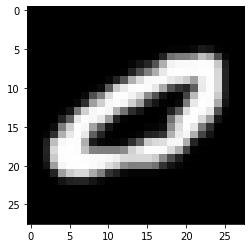

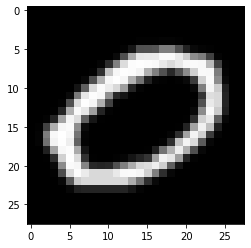

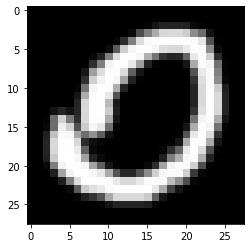

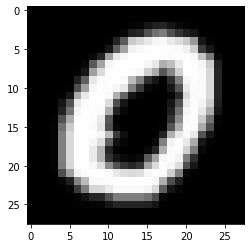

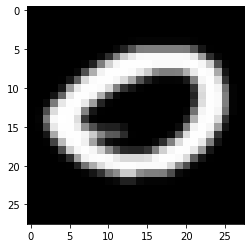

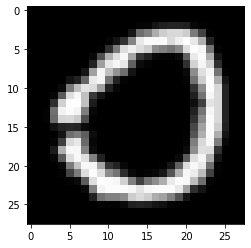

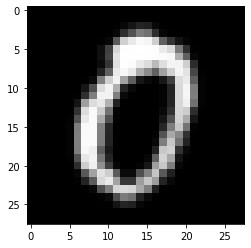

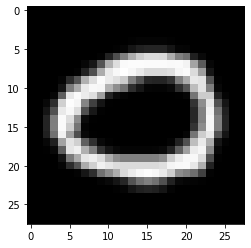

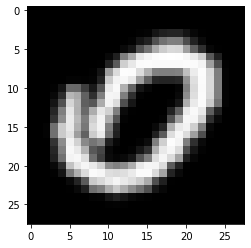

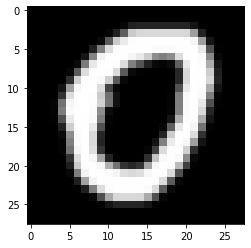

In [0]:
#查看提取出来的图片，以1为例,看看是否有误:没有错误
from matplotlib import pyplot as plt
#print(class_[0][i])
for i in range(10):
  plt.imshow(class_[0][i], cmap='gray', aspect='equal')
  plt.grid(False)
  _=plt.show()

### 构造平衡的测试集

In [0]:
'''
emnist中的数字测试集是平衡的，可以直接拿来用，共40000张图片，平均分给50个客户端
'''

In [0]:
#删除一个h5py文件
f_t.flush()
f_t.clear()

In [0]:
#创建文件
f_t = h5py.File("/content/drive/My Drive/Colab Notebooks/TEST.hdf5","w")
top_group = f_t.create_group("examples")

In [0]:
#将10个类别平均放到50个客户端中，每个客户端每个类别放80个
import random
NUM_CLIENTS = 50  #写的时候最初用50，用500时间太长
NUM_PER_CLASS = 80
NUM_CLASS = 10

pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
client_ids = []

for i in range(len(y_test_emnist_digits)):
  #随机产生一个客户端的下标然后将该图片给放进去
    random_client_id = random.randint(0, NUM_CLIENTS-1)
    pixels[random_client_id].append(x_test_emnist_digits[i]/255.0)
    label[random_client_id].append(y_test_emnist_digits[i])
    
#将pixels和label加入对应client的group中
for i in range(NUM_CLIENTS):
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(num_per_class(label[i]))


[84 88 68 89 59 92 80 74 94 72]
[94 99 87 79 90 90 75 84 82 79]
[92 83 85 85 59 67 59 86 79 86]
[88 74 71 99 77 80 86 74 77 79]
[81 87 85 66 86 83 88 75 73 74]
[75 85 89 75 74 86 76 79 86 80]
[77 94 84 74 94 82 83 91 89 89]
[99 71 91 80 76 91 97 75 65 84]
[75 82 74 72 83 86 65 80 85 67]
[72 84 73 80 79 86 76 75 79 75]
[77 75 84 66 80 89 70 89 77 68]
[73 76 78 76 83 61 74 82 81 85]
[ 68  88  98  91 101  81  77  75  76  82]
[78 77 82 75 78 89 99 94 62 75]
[80 75 81 80 92 72 70 94 77 94]
[89 66 83 76 78 94 86 79 92 83]
[86 84 77 88 74 78 87 91 83 81]
[83 87 92 83 83 77 85 81 75 90]
[ 80  79  88  72  78  88  86  82  72 104]
[ 67  80  94  75 102  75  85  61  91  72]
[77 86 81 85 83 67 85 73 76 87]
[86 92 69 93 86 72 83 84 83 80]
[82 78 67 77 64 75 77 85 80 82]
[81 77 78 79 74 92 75 69 81 82]
[101  72  72  80  80  87  79  80  88  77]
[80 81 78 68 76 86 86 85 73 90]
[79 80 64 75 86 66 79 71 73 86]
[85 82 85 87 91 77 82 74 84 71]
[69 88 73 83 64 76 71 94 77 91]
[78 78 78 86 78 78 63 79 72 85]


In [0]:
#查看数量是否有误
# num1 = 0
# num2 = 0
# for j in range(NUM_CLIENTS):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)
# print(len(y_test_emnist_gidits))

#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(10):
  print(f_t["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f_t["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
f_t.close()
del pixels[:]
del label[:]
gc.collect()

ERROR:asyncio:Task was destroyed but it is pending!
task: <Task pending coro=<trace.<locals>.async_trace() running at /usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/common_libs/tracing.py:281> wait_for=<Future pending cb=[_chain_future.<locals>._call_check_cancel() at /usr/lib/python3.6/asyncio/futures.py:403, <TaskWakeupMethWrapper object at 0x7fc71b1f6d08>()]> cb=[<TaskWakeupMethWrapper object at 0x7fc75494a2e8>()]>


26972

### 构造BAL1数据集，标量平衡，全局平衡，局部IID

In [0]:
'''
K=100，每个客户端600张图片，每一类50张图片
'''

In [0]:
#当创建数据集需要修改的时候就要用这里，先清空再重新创建
f1.flush()
f1.clear()

In [0]:
#设置各个不平衡的数据集，首先弄一个BAL1:10个类别，每个类别数目相等，每个用户都含有10个类别且每类数目相等
#我调查的结果是每个label数目在5000-6000张之间，于是分给500个客户端差不多每个客户端均10个
#创建自己的数据集首先是BAL1：全平衡，使用了mnist数据集来分配，60000张图片平均分给500个客户端，每个客户端分得10类，每类10张，供100张图片
f1 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL1.hdf5","a")
top_group = f1.create_group("examples")   #创建顶层group名为examples

In [0]:
bal1_balance_class = [[]for i in range(10)]  
for i in range(0,10):
  bal1_balance_class[i] = class_[i][0:6000]

In [0]:
MY_NUM_CLIENTS = 100  #写的时候最初用50，用500时间太长，试过500，磁盘会从30G飙升到60G且还运行不完，不知道后面500个客户端的时候怎么办
NUM_PER_CLASS = 60  #每个客户端每类的图片数量
NUM_CLASS = 10
#Collections.Orderdict->TensorSliceDataset+client_id->hdf5->HDF5ClientData
#<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>

pixels = []
label=[]
client_ids = []
for i in range(MY_NUM_CLIENTS):  #i客户端数量
  for j in range(10):  #j是类别数
    for k in range(NUM_PER_CLASS): #k控制每一类图片放多少张在客户端
      pixels.append(bal1_balance_class[j][i*NUM_PER_CLASS+k]/255.0) #转成0-1之内的数字再加入pixels，class_[j]存放的是第j类数
      label.append(j)  #加入label
  
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))  #创建以client_id为名字的group
  label_ds = temp_group.create_dataset(name="label", data=np.array(label, dtype='int32'))  #向group中写入label
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels, dtype='float32'))  #向group中写入pixels
  
  print(num_per_class(label))
  #清空上一个pixels数组和label数组中存放的上一个客户端的数据信息,否则会有灾难！！！
  pixels.clear()
  label.clear()


1


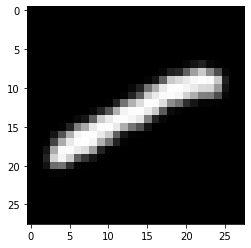

1


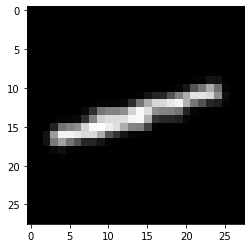

1


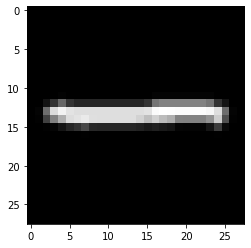

1


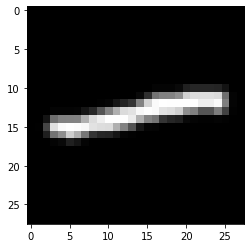

1


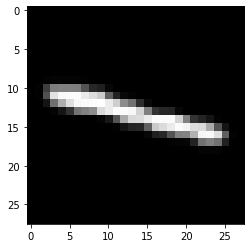

1


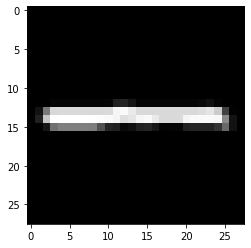

1


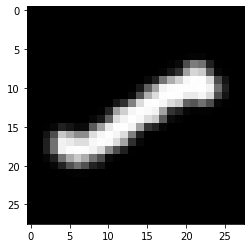

1


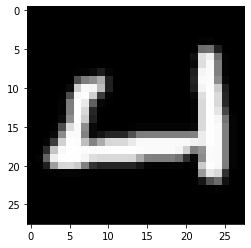

1


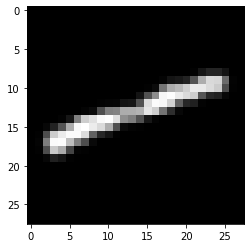

1


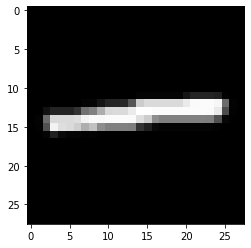

In [0]:
#查看数量是否有误



#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(100,110):
  print(f1["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f1["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完了以后，调用内存清理操作
f1.close()
del pixels[:]
del label[:]
del bal1_balance_class[:]
gc.collect()

0

### 构造BAL2数据集：标量平衡且全局平衡，局部Non-IID

In [0]:
#构造BAL2
'''
标量平衡:每个本地600张
全局平衡：共10个类，每个类6000张
局部平衡：随机
num_clients = 100
'''

'\n标量平衡:每个本地100张\n全局平衡：共10个类，每个类10张\n局部平衡：随机\nnum_clients = 500\n'

In [0]:
#构造绝对平衡图片集,10张*10类*500个客户端
#因为后面构造数据集的时候对bal2_balance_class进行了删除操作，因此每次生成数据集都要重新生成bal2_balance_class
bal2_balance_class = [[]for i in range(10)]  
for i in range(0,10):
  bal2_balance_class[i] = class_[i][0:6000]

In [0]:
#删除一个h5py文件
f2.flush()
f2.clear()

In [0]:
#创建hdf5文件
f2 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL2-20.hdf5","a")
#创建顶层group
top_group = f2.create_group("examples")

In [0]:
#创建BAL2:使用了洗牌算法(弃了，Non-IID性不够)
#另外的方法：按label划分以后每300张为一个碎片，每个用户随机分配两个碎片
#将10个类别平均放到500个客户端中，每个客户端每个类别放12个
import random
NUM_CLIENTS = 100  #写的时候最初用50，用500时间太长
NUM_CLASS = 10
NUM_PER_CLASS = 60
CHIP_SIZE = 20
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE


pixels = []
label=[]
client_ids = []

for i in range(NUM_CLIENTS):  #i客户端数量 
  j = 0
  #j是每个客户端控制取多少张图片
  #使用while循环方便控制当选到label是i但是i已经被之前的客户端选择完了的情况，增设j控制
  while(j<NUM_CHIP):
    index_label = random.randint(0, NUM_CLASS-1) #随机产生一个label下标
    num_remain_pixels = len(bal2_balance_class[index_label])
    if(num_remain_pixels>0):
      for k in range(CHIP_SIZE):
        pixels.append(bal2_balance_class[index_label][k]/255.0)
        label.append(index_label)  #加入label
      del bal2_balance_class[index_label][0:CHIP_SIZE]
      j = j+1
  
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label, dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels, dtype='float32'))

  print(len(label))
  print(num_per_class(label))
  pixels.clear()
  label.clear()

600
[ 80 140  40 140  40  20  20  20  60  40]
600
[80 60 80 80 60 40 60 20 40 80]
600
[100 100  40  40   0  60 100  60  40  60]
600
[ 80  60 100  20  20  40  60 120  60  40]
600
[ 80  80  20  20  60  80 120  40  40  60]
600
[ 40  40 100  20 120  60  80  40  40  60]
600
[ 40  40 100 120  80  40  40  60  60  20]
600
[100  80 140  20  80  40  60  40  20  20]
600
[100  20  60  60  60  80  40  40  80  60]
600
[ 60  60  60  20 100  60  80  80  20  60]
600
[ 60  40  20 100 120  20  40  20  60 120]
600
[ 20  60  80 120  20  40  60  20  80 100]
600
[100  80  20   0  80  40  60 100  40  80]
600
[100  40  80  60 100  40  20  40  80  40]
600
[ 20  60  20  80  80  40  20  40  80 160]
600
[ 60 120  40  40   0  80  40  40 100  80]
600
[ 40 100 100  60  40 100  20  60  80   0]
600
[ 20  60  80  60  40  80  40  80  40 100]
600
[ 20 100  20 120  60  40  40  60  40 100]
600
[ 20  80  40  80  40  60  80  20  60 120]
600
[ 60 100  40 140  60  20 100  80   0   0]
600
[ 60  20  60 100 100   0  80  40 100  40

In [0]:
#查看数量是否有误
# num1 = 0
# num2 = 0
# for j in range(NUM_CLIENTS):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)

#查看某个客户端每个类别分别有多少
def num_per_class(label):
  num = np.zeros(shape=(10), dtype='int32')
  for i in range (len(label)):
    l = label[i]
    num[l] = num[l] + 1
  return num

# for i in range(NUM_CLIENTS):
#   print(num_per_label(label[i]))

#print(num)


#随机画图看是否有误:无误
#把图片画出来看一看
a = 9
for i in range(10):
  print(f2["examples"][client_ids[a]]["label"].value[i])
  plt.imshow(f2["examples"][client_ids[a]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完成以后，调用内存清理操作
f2.close()
del bal2_balance_class[:]
del pixels[:]
del label[:]
gc.collect()

1609

### 构造BAL3数据集：全局平衡，标量不平衡，局部Non-IID

In [0]:
'''
构造BAL3数据集
全局平衡：10个label，每个label6000张图片
标量不平衡，局部Non-IID
客户端：100，C=0.02
60000张图片随机分给100个用户
客户端样本数分布：
[  58   74   87   87  107  111  131  141  174  181  186  222  203  242
  287  284  316  352  351  388  390  470  450  519  519  550  661  617
  661  678  761  691  777  866  915  897  969  939 1011 1037  977  998
 1041 1105 1083 1181 1131 1174 1143 1149 1187 1201 1103 1179 1091 1150
 1145 1084 1099  994 1012 1076 1038  949  961  926  865  837  777  763
  753  715  651  617  600  529  564  499  483  470  420  426  375  329
  325  269  248  252  241  213  176  184  143  152  128   92  101   95
   99   72]
'''

In [0]:
#定义呈正态分布的客户端数量
NUM_CLIENTS = 100
miu = 0
sigma = 35
num_clients = np.zeros(shape=(NUM_CLIENTS),dtype=int)
for _ in range(110000):
  nor = random.normalvariate(miu,sigma)
  if(nor>=0 and nor<=100):
    index = math.floor(nor)
    num_clients[index] = num_clients[index] + 1
_n_ = 60000 - sum(num_clients)
for _ in range(_n_):
  r_id =  random.randint(0,NUM_CLIENTS-1)
  num_clients[r_id] = num_clients[r_id] + 1

print(_n_)
print(num_clients)
print(sum(num_clients))

5263
[1319 1339 1321 1273 1247 1276 1280 1364 1216 1217 1233 1192 1233 1189
 1204 1224 1231 1152 1143 1111 1082 1087 1072 1079 1051  994  960  967
  952  867  937  958  894  844  839  802  789  729  731  705  631  638
  689  646  601  571  550  578  542  503  540  534  483  411  443  435
  406  368  379  332  330  304  287  290  284  281  297  257  229  238
  212  226  216  217  200  186  163  154  145  151  114  128  138  116
  120  115   99   94   95   92  109   96   87   73   86   78   69   72
   82   87]
60000


In [0]:
print(num_clients)

[1319 1339 1321 1273 1247 1276 1280 1364 1216 1217 1233 1192 1233 1189
 1204 1224 1231 1152 1143 1111 1082 1087 1072 1079 1051  994  960  967
  952  867  937  958  894  844  839  802  789  729  731  705  631  638
  689  646  601  571  550  578  542  503  540  534  483  411  443  435
  406  368  379  332  330  304  287  290  284  281  297  257  229  238
  212  226  216  217  200  186  163  154  145  151  114  128  138  116
  120  115   99   94   95   92  109   96   87   73   86   78   69   72
   82   87]


In [0]:
#获得全局绝对平衡数据集
bal3_p = []
bal3_l = [] 
for i in range(0,10):
  for j in range(6000):
    bal3_p.append(class_[i][j])
    bal3_l.append(i)
print(len(bal3_l))

60000


In [0]:
#删除一个h5py文件
f3.flush()
f3.clear()

In [0]:
#创建hdf5文件
f3 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL3-3.hdf5","a")
#创建顶层group
top_group = f3.create_group("examples")

In [0]:
#创建BAL3
#将60000张图片随机分给100个客户端:洗牌算法

NUM_CLIENTS = 100  
NUM_CLASS = 10
NUM_PER_CLASS = 6000
CHIP_SIZE = 100
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE

#pixels[i]存放的是第i个客户端的图片，label[i]以此类推
pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
client_ids = []

for i in range(NUM_CLIENTS):
  for _ in range(num_clients[i]):
    random_pid = random.randint(0, len(bal3_p)-1)
    pixels[i].append(bal3_p[random_pid]/255.0)
    label[i].append(bal3_l[random_pid])
    del bal3_p[random_pid]
    del bal3_l[random_pid]

#将pixels和label加入对应client的group中
num = 0
for i in range(NUM_CLIENTS):
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(len(label[i]))
  print(num_per_class(label[i]))

1319
[120 131 114 124 142 133 127 144 148 136]
1339
[138 126 128 105 143 142 131 131 143 152]
1321
[128 123 116 154 130 127 132 138 128 145]
1273
[129 141 139 130 121 113 118 131 125 126]
1247
[141 144 147 117 124 110 117 110 124 113]
1276
[127 117 125 138 146 125 129 121 112 136]
1280
[113 135 116 131 118 132 144 138 122 131]
1364
[151 129 135 145 131 153 107 164 115 134]
1216
[102 109 137 133 113 145  97 114 136 130]
1217
[127 111 128 102 134 140 120 115 113 127]
1233
[130 123 124 131 117 110 130 125 127 116]
1192
[134 116 115 112 114 123 108 121 127 122]
1233
[117 132 125 116 127 122 130  99 141 124]
1189
[101 103 125 123 123 148 130 103 100 133]
1204
[126 120 115 121 111 127 109 133 123 119]
1224
[112 130 124 139 124 121 106 122 122 124]
1231
[109 138 129 119 129 119 124 133 114 117]
1152
[104 107 115 111  98 115 141 117 126 118]
1143
[129 114 108 107 127 106 120 119 108 105]
1111
[123 116 106 106 111 110 114 112 101 112]
1082
[115 111  95 108 104 118 111 111 117  92]
1087
[102  99

7


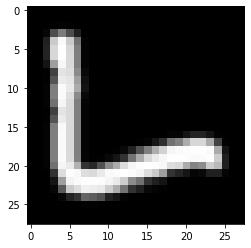

3


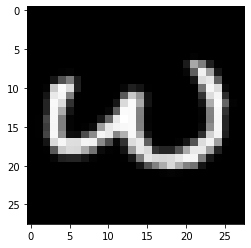

3


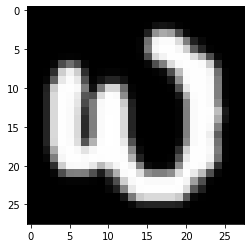

3


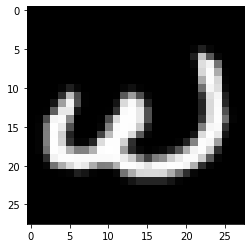

1


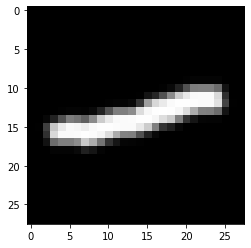

0


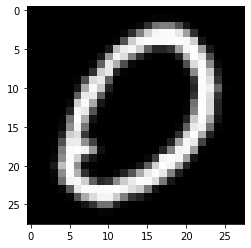

3


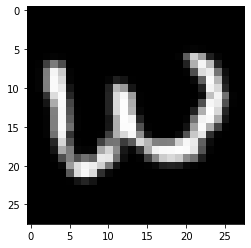

6


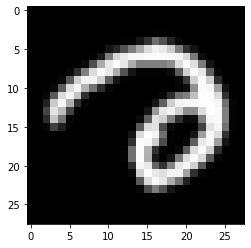

9


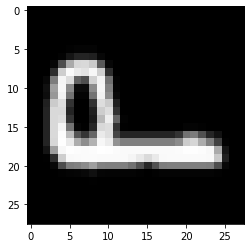

8


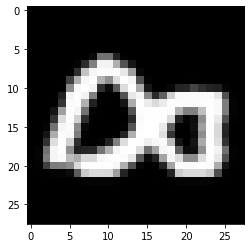

In [0]:
# #查看总的数量是否有误:无误
# num1 = 0
# num2 = 0
# for j in range(5):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)

#len(f3["examples"][client_ids[2]]["label"].value)
# print(f3["examples"][client_ids[3]]["label"].value[699])
# plt.imshow(f3["examples"][client_ids[3]]["pixels"].value[699], cmap='gray', aspect='equal')
# plt.grid(False)
# #这里这个画应该是一种很随意的，因为不想再用所以命名就是_
# #plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
# _=plt.show()

#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(20,30):
  print(f3["examples"][client_ids[5]]["label"].value[i])
  plt.imshow(f3["examples"][client_ids[5]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
#数据集构造完成以后，调用内存清理操作
f3.close()
del pixels[:]
del label[:]
del bal3_balance_class[:]
gc.collect()

23441

In [0]:
f3.close()

### 构造BAL4数据集，全局不平衡，标量不平衡，局部Non-IID

In [0]:
'''
BAL4：标量不平衡，全局不平衡，局部不平衡
使用原始的mnist
60000张图片随机分给100个客户端，每个客户端数目不固定
客户端样本分布见BAL3
类别数量分布：
[ 1166  2692  5548  9145 11536 11574  8958  5598  2731  1052]
'''

In [0]:
#定义呈正态分布的客户端数量
NUM_CLIENTS = 100
miu = 50.5
sigma = 21
num_clients = np.zeros(shape=(NUM_CLIENTS),dtype=int)
for _ in range(61000):
  nor = random.normalvariate(miu,sigma)
  if(nor>=0 and nor<=100):
    index = math.floor(nor)
    num_clients[index] = num_clients[index] + 1
_n_ = 60000 - sum(num_clients)
for _ in range(_n_):
  r_id =  random.randint(0,NUM_CLIENTS-1)
  num_clients[r_id] = num_clients[r_id] + 1

print(_n_)
print(num_clients)
print(sum(num_clients))

1
[  68   77   82  103  114  100  107  151  164  152  170  206  219  245
  236  286  321  331  347  392  398  444  466  501  532  571  623  648
  642  690  705  775  807  831  870  919  923 1008  910 1005 1055 1029
 1074 1118 1109 1133 1121 1139 1124 1151 1165 1188 1116 1126 1249 1128
 1111 1143 1153 1037 1020 1042  947  948  953  920  879  859  825  781
  719  654  628  655  601  571  536  509  486  425  465  387  375  347
  292  315  286  247  220  202  182  169  171  181  143  115   91   99
   77   70]
60000


In [0]:
#定义呈正态分布的各类别数量
NUM_CLASS = 10
miu_c = -0.1
sigma_c = 3
num_class = np.zeros(shape=(NUM_CLASS),dtype=int)
for _ in range(120000):
  nor = random.normalvariate(miu_c,sigma_c)
  if(nor>=0 and nor<=10):
    index = math.floor(nor)
    num_class[index] = num_class[index] + 1
_n_ = 60000 - sum(num_class)
for _ in range(_n_):
  r_id =  random.randint(0,NUM_CLASS-1)
  num_class[r_id] = num_class[r_id] + 1

print(_n_)
print(num_class)
print(sum(num_class))


1868
[15836 13861 11049  7918  5186  2975  1621   822   456   276]
60000


In [0]:
print(num_clients)

[1319 1339 1321 1273 1247 1276 1280 1364 1216 1217 1233 1192 1233 1189
 1204 1224 1231 1152 1143 1111 1082 1087 1072 1079 1051  994  960  967
  952  867  937  958  894  844  839  802  789  729  731  705  631  638
  689  646  601  571  550  578  542  503  540  534  483  411  443  435
  406  368  379  332  330  304  287  290  284  281  297  257  229  238
  212  226  216  217  200  186  163  154  145  151  114  128  138  116
  120  115   99   94   95   92  109   96   87   73   86   78   69   72
   82   87]


In [0]:
#获取总的数据集：最开始使用了洗牌算法，后来发现随机的还是有点平衡，最后改用认为控制类别比例
#因为需要使用删除操作所以不能直接使用=赋值
bal4_p = []
bal4_l = []
#获得全局不平衡数据集，各个类别之间的数量基本呈正态分布  
for i in range(10):
  end = num_class[i]
  for k in range(end):
    bal4_p.append(class_[i][k])
    bal4_l.append(i)
print(len(bal4_p))


60000


In [0]:
#因为构造的数据集有误，所以需要看总的图片是否有误
#第一次查看：有误.第二次查看：有误

# for i in range(10,20):
#   print(y_class[i])
#   plt.imshow(x_class[i], cmap='gray', aspect='equal')
#   plt.grid(False)
#   _=plt.show()


[1166, 2692, 5548, 9145, 11536, 11574, 8958, 5598, 2731, 1052]


In [0]:
#删除一个h5py文件
f4.flush()
f4.clear()

In [0]:
#创建hdf5文件
f4 = h5py.File("/content/drive/My Drive/Colab Notebooks/BAL4-3.hdf5","a")
#创建顶层group
top_group = f4.create_group("examples")

In [0]:
#创建BAL4
#将60000张图片随机分给100个客户端，为了达到病态的效果，以CHIP_SIZE张图片为一个碎片，将碎片随机分给100个客户端

NUM_CLIENTS = 100 
NUM_CLASS = 10
#NUM_PER_CLASS = 600
CHIP_SIZE = 100
NUM_CHIP = NUM_CLASS * NUM_PER_CLASS // CHIP_SIZE

pixels = [[]for i in range(NUM_CLIENTS)]
label = [[]for i in range(NUM_CLIENTS)]
#client_ids = []
#外层循环控制客户端数随机从样本中挑选num_clients[i]个样本
#这里有一个问题就是数目越多的样本被选到的概率越大，而不是所有样本被选到的概率相同
#由于在全局类别样本呈正态分布因此在每个客户端里面样本也是正态分布
for i in range(NUM_CLIENTS):
  for _ in range(num_clients[i]):
    random_pid = random.randint(0, len(bal4_p)-1)
    pixels[i].append(bal4_p[random_pid]/255.0)
    label[i].append(bal4_l[random_pid])
    del bal4_p[random_pid]
    del bal4_l[random_pid]

    
#将pixels和label加入对应client的group中
num = 0
for i in range(NUM_CLIENTS):
  # client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))
  label_ds = temp_group.create_dataset(name="label", data=np.array(label[i], dtype='int32'))
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels[i], dtype='float32'))
  print(len(label[i]))
  print(num_per_class(label[i]))
  num = num + len(label[i])
#统计最终分给100个客户端的样本总数是多少  
print(num)

1319
[361 297 232 166 129  70  30  17  11   6]
1339
[348 342 214 213 115  53  31  10   6   7]
1321
[354 285 263 167  94  74  47  24  10   3]
1273
[331 307 249 163 101  62  27  18  10   5]
1247
[356 291 225 137 112  54  40  16  11   5]
1276
[369 285 241 162  99  49  33  23  10   5]
1280
[349 295 216 173 114  66  33  19   8   7]
1364
[351 309 256 190 126  65  31  17  12   7]
1216
[294 263 250 165 106  72  33  19   7   7]
1217
[302 278 257 168 101  54  29  12  11   5]
1233
[330 273 208 167 121  58  43  17  11   5]
1192
[295 271 216 191  90  60  32  16  13   8]
1233
[342 271 248 152  98  52  35  15  14   6]
1189
[342 259 219 144 101  73  29  12   5   5]
1204
[321 284 213 146 103  74  29  21   5   8]
1224
[308 282 256 147 114  53  32  16  12   4]
1231
[289 287 231 168 121  64  36  26   4   5]
1152
[296 281 230 143  99  44  32  14   6   7]
1143
[294 262 205 142  95  77  26  25  12   5]
1111
[285 249 203 151  96  61  36  14  11   5]
1082
[285 255 193 137  82  68  34  13   8   7]
1087
[273 250

In [0]:
#查看数量是否有误
num1 = 0
num2 = 0
for j in range(5):
  #print("pixels",len(pixels[j]))
  num1 = num1 + len(pixels[j])
  num2 = num2 + len(label[j])
  #print("label",label[j])
print(num1)
# # print(num2)

#随机画图看是否有误:第一次有误，label和图片对不上
#把图片画出来看一看
# for i in range(10):
#   print(f3["examples"][client_ids[3]]["label"].value[i])
#   plt.imshow(f3["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
#   plt.grid(False)
#   plt.show()

3000


In [0]:
#数据集构造完成以后，调用内存清理操作
f4.close()
del pixels[:]
del label[:]
del bal4_p[:]
del bal4_l[:]
#del bal4_imbalance_class[:]
gc.collect()

0

### 服务器端数据

In [0]:
#此数据用于服务器端：服务器端自行设置一个数据集

In [7]:
#数据准备,取不同于数据集的另外60000作为服务器的数据
server_balance_class = [[]for i in range(10)]
for i in range(10):
  for j in range(6000,12000):
    server_balance_class[i].append(class_[i][j]/255.0)  #将像素值处理到0-1之间
len(server_balance_class[0])

6000

In [0]:
#删除一个h5py文件
f_server.flush()
f_server.clear()

In [0]:
#创建文件
f_server = h5py.File("/content/drive/My Drive/Colab Notebooks/SERVER.hdf5","a")
top_group = f_server.create_group("examples")

In [0]:
MY_NUM_CLIENTS = 2  #写的时候最初用50，用500时间太长，试过500，磁盘会从30G飙升到60G且还运行不完，不知道后面500个客户端的时候怎么办
NUM_PER_CLASS = 100  #每个客户端每类的图片数量
NUM_CLASS = 10

pixels = []
label=[]
client_ids = []
for i in range(MY_NUM_CLIENTS):  #i客户端数量
  for j in range(10):  #j是类别数
    for k in range(NUM_PER_CLASS): #k控制每一类图片放多少张在客户端
      pixels.append(server_balance_class[j][i*NUM_PER_CLASS+k]/255.0) #转成0-1之内的数字再加入pixels，class_[j]存放的是第j类数
      label.append(j)  #加入label
  
  client_ids.append("f00_" + str(i))
  temp_group = top_group.create_group(name="f00_" + str(i))  #创建以client_id为名字的group
  label_ds = temp_group.create_dataset(name="label", data=np.array(label, dtype='int32'))  #向group中写入label
  pixels_ds = temp_group.create_dataset(name="pixels", data=np.array(pixels, dtype='float32'))  #向group中写入pixels
  
  print(num_per_class(label))
  #清空上一个pixels数组和label数组中存放的上一个客户端的数据信息,否则会有灾难！！！
  pixels.clear()
  label.clear()


[100 100 100 100 100 100 100 100 100 100]
[100 100 100 100 100 100 100 100 100 100]


In [0]:
#查看数量是否有误
# num1 = 0
# num2 = 0
# for j in range(NUM_CLIENTS):
#   #print("pixels",len(pixels[j]))
#   num1 = num1 + len(pixels[j])
#   num2 = num2 + len(label[j])
#   #print("label",label[j])
# print(num1)
# print(num2)
# print(len(y_test_emnist_gidits))

#随机画图看是否有误:无误
#把图片画出来看一看
for i in range(10):
  print(f_server["examples"][client_ids[3]]["label"].value[i])
  plt.imshow(f_server["examples"][client_ids[3]]["pixels"].value[i],cmap='gray')
  plt.grid(False)
  plt.show()

In [0]:
f_server.close()
del server_balance_class[:]
del pixels[:]
del label[:]
gc.collect()

0

In [0]:
f_server.close()

### 关闭文件操作

In [0]:
#f_t.close()
# f1.close()
# f2.close()
f3.close()
f4.close()

### 各个数据集实例化

In [8]:
#实例化构造的数据集:test
test = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/test.hdf5")
num_clients_test = len(test.client_ids)
print(num_clients_test)

50


In [9]:
#实例化服务器数据：server
server = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/SERVER.hdf5")
num_clients_server = len(server.client_ids)
print(num_clients_server)

2


In [10]:
#实例化构造的数据集：BAL1
BAL1 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL1.hdf5")
num_clients_BAL1 = len(BAL1.client_ids)
print(num_clients_BAL1)
#留出总客户端的4分之一做测试集
#BAL1_train, BAL1_test = BAL1.train_test_client_split(client_data=BAL1, num_test_clients= num_clients_BAL1//4)

100


In [11]:
#实例化构造的数据集：BAL2
BAL2 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL2-1.hdf5")
num_clients_BAL2 = len(BAL2.client_ids)
print(num_clients_BAL2)
#留出总客户端的4分之一做测试集
#BAL2_train, BAL2_test = BAL2.train_test_client_split(client_data=BAL2, num_test_clients= num_clients_BAL2//4)

100


In [12]:
#实例化构造的数据集：BAL3.BAL3-1、BAL4-1、BAL4-2的客户端样本数分布是一样的，BAL4-2是一边倒类别分布
#4-3和3-3都是使用的一边倒类别分布、一边倒客户端数量分布
BAL3 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL3-1.hdf5")
num_clients_BAL3 = len(BAL3.client_ids)
#print(num_clients_BAL3)

#使用了迭代器发现确实BAL3里面的客户端样本数和分配给它的不一样
example_dataset = BAL3.create_tf_dataset_for_client(
    BAL3.client_ids[2]
)
example_element = next(iter(example_dataset))

print(BAL3.client_ids[0:20])

# print(num_per_class(l))
# print(example_element['label'].numpy() )
# plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
# plt.grid(False)
# #这里这个画应该是一种很随意的，因为不想再用所以命名就是_
# #plt.imshow（）负责对图像进行处理并调整其格式但是不能显示，必须在其后跟着plt.show()才能成功显示出来
# _=plt.show()

['f00_0', 'f00_1', 'f00_10', 'f00_11', 'f00_12', 'f00_13', 'f00_14', 'f00_15', 'f00_16', 'f00_17', 'f00_18', 'f00_19', 'f00_2', 'f00_20', 'f00_21', 'f00_22', 'f00_23', 'f00_24', 'f00_25', 'f00_26']


In [13]:
#实例化构造的数据集：BAL4，BAL4-2是最终的一边倒类别正态分布数据集，BAL4-3是客户端数量、类别都一边倒
BAL4 = tff.simulation.hdf5_client_data.HDF5ClientData("/content/drive/My Drive/Colab Notebooks/BAL4-2.hdf5")
num_clients_BAL4 = len(BAL4.client_ids)
print(num_clients_BAL4)
example_dataset = BAL4.create_tf_dataset_for_client(
    BAL4.client_ids[4]
)
example_element = next(iter(example_dataset))

print(BAL4.client_ids[0:20])

#调查，第2个客户端只分配了300个样本，但是用迭代器迭代出来了600个样本,全部都可以实例化


100
['f00_0', 'f00_1', 'f00_10', 'f00_11', 'f00_12', 'f00_13', 'f00_14', 'f00_15', 'f00_16', 'f00_17', 'f00_18', 'f00_19', 'f00_2', 'f00_20', 'f00_21', 'f00_22', 'f00_23', 'f00_24', 'f00_25', 'f00_26']


In [0]:
print(len(test.client_ids))

50


In [0]:
#BAL1.client_ids
#这里面的每一个打印出来都是和example_dataset类型一样的
x = tf.data.Dataset.from_tensor_slices(
        collections.OrderedDict((name, ds.value) for name, ds in sorted(
            f1["examples"][BAL1.client_ids[0]].items())))
print(x)
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)
print(example_dataset)

<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>
<TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>


In [0]:
#此处得到客户端的总数K，因为每一轮随机选择C×K的向上取整
#根据FedAvg做的研究C取0.2可获得较好的性能，为了简化模型K这里取固定的数
# K = len(emnist_train.client_ids)
#BAL1数据集
K = len(BAL4.client_ids)
C = 0.02
math.ceil(K*C)

8

In [0]:
#这个单元格在看数据集里面的图片是否正常
#第一次：test的label和图片匹配不上
example_dataset = BAL1.create_tf_dataset_for_client(
    BAL1.client_ids[3]
)

example_element = next(iter(example_dataset))
print(example_element['label'].numpy())  #加了.numpy（）是在取numpy()属性的值，就是用.取属性值的意思

from matplotlib import pyplot as plt
plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_=plt.show()

### 图像预处理

In [0]:
#计算L中每个类别有多少个样本,L代表了数据集的numpy列表形式
def num_per_class_in_list(L):
  len_L = len(L)
  num_class = np.zeros(shape=(10), dtype="int32") 
  for i in range (len_L):
    index = L[i]["label"]
    num_class[index] = num_class[index] + 1
  return num_class

In [0]:
#将dataset中类别样本平衡到平均值
def primary_balance(dataset):
  l_ds = list(dataset.as_numpy_iterator())
  l_ex = len(l_ds)
  
  #获得每个类别样本数
  num_class = num_per_class_in_list(l_ds)
  #获得样本类别
  num_label = 0
  for x in num_class:
    if(x > 0):
      num_label = num_label+1
  #获得所有类样本平均数,这里应该将10改成样本类别个
  avg = int(round(sum(num_class)/10))
  # result = [round(avg/x) for x in num_class]

  label_ = []
  pixels_ = []
  #将l_ds中的样本增强到avg那么多个
  DAfunction = ["tf.image.random_flip_left_right","tf.image.random_flip_up_down"]
  for i in range (l_ex):
    label_i = l_ds[i]["label"]
    #样本数少于平均数则增强，现在就简单repeat
    #样本数少于平均数并且和平均数差别很大的才repeat    
    if(num_class[label_i] < avg and round(avg/num_class[label_i])>=2):
    # if(num_class[label_i] < avg):
      while(num_class[label_i] <= avg):
        label_.append(label_i)
        #使用数据增强
        r = random.randint(0,1)
        img = tf.reshape(l_ds[i]["pixels"],[-1,28,28,1])
        img = eval(DAfunction[r])(img)
        img = tf.reshape(img,[28,28])          
        pixels_.append(img)
        num_class[label_i] = num_class[label_i] + 1
    else:
      label_.append(label_i)
      pixels_.append(l_ds[i]["pixels"])
  #将repeat之后的l_ds转换成dataset类型并返回
  return tf.data.Dataset.from_tensor_slices(collections.OrderedDict(
      label=np.array(label_,dtype="int32"),
      pixels=np.array(pixels_,dtype="float32")))
  #return reslut


In [0]:
#NUM_CLIENTS在实验的时候应该是K×C,375*0.2=75
#NUM_CLIENTS = math.ceil(K*C)
NUM_EPOCHS = 5  #
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

#预处理，将图片中的‘pixels'、‘label'分别表示成x和y
def preprocess(dataset,avg):
  #内部函数将像素和标签转换成x和y，并将像素展平
  def batch_format_fn(element):
    return collections.OrderedDict(
        #因为是灰度图所以通道数为1，如果是rgb图片则为3
        #因为CNN卷积层接收一个4d向量
        x = tf.reshape(element['pixels'], [-1,28,28,1]),
        y = tf.reshape(element['label'], [-1,1])
    )

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [0]:
#为指定用户创建联邦数据,接收训练集和用户id
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x),0)
      for x in client_ids
    ]


In [0]:
#NUM_CLIENTS在实验的时候应该是K×C,375*0.2=75
#NUM_CLIENTS = math.ceil(K*C)
NUM_EPOCHS = 5  #
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

#预处理，将图片中的‘pixels'、‘label'分别表示成x和y
def new_preprocess(dataset,avg):
  #内部函数将像素和标签转换成x和y，并将像素展平
  def batch_format_fn(element):
    return collections.OrderedDict(
        #因为是灰度图所以通道数为1，如果是rgb图片则为3
        #因为CNN卷积层接收一个4d向量
        x = tf.reshape(element['pixels'], [-1,28,28,1]),
        y = tf.reshape(element['label'], [-1,1])
    )
  #简单repeat
  #dataset = primary_balance(dataset)
  #计算当前客户端应该自适应repeat多少次
  num_self_epochs = round(avg/len(list(dataset.as_numpy_iterator())))
  #print("num_self_epochs",num_self_epochs)
  if(num_self_epochs > 1):
    dataset = dataset.repeat(num_self_epochs)

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)
#为指定用户创建联邦数据,接收训练集和用户id
def new_make_federated_data(client_data, client_ids):
  #计算该批次客户端的平均样本数
  def cal_avg_for_batch(datasets):
    num = 0
    for ds in datasets:
      num = num + len(list(ds.as_numpy_iterator()))
    return num/len(datasets)

  #将每个客户端的样本类别数平衡到该客户端的平均值
  datasets = []
  for x in client_ids:
    datasets.append(primary_balance(client_data.create_tf_dataset_for_client(x)))
  
  #获得该批次客户端平均样本数
  avg_clients = cal_avg_for_batch(datasets)
  #print("avg_clients",avg_clients)

  return [
      new_preprocess(ds,avg_clients)
      for ds in datasets
    ]


In [0]:
#这里改成随机获得NUM_CLIENTS个用户，模拟联邦学习每轮的随机选择用户
# sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)
# federated_train_data = make_federated_data(emnist_train, sample_clients)
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
example_dataset = BAL4.create_tf_dataset_for_client(
    BAL4.client_ids[0]
)
#OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>
#然后再切片就变成了数据集
print("examle_dataset",example_dataset)
example_element = next(iter(example_dataset))

#dataset.repeat(NUM_EPOCH)中的dataset就是这些，所以得想办法把dataset玩清楚，怎么重复
#我想了一种变换该数据集的数并使得方差最小
#样本各观测值与平均数之差的平方和最小，所以将少的样本增强到平均数个，多的样本不处理
#计算每个类别的平均数，这里取最接近该平均数的整数，然后进行样本增强

l_ds = list(example_dataset.as_numpy_iterator())
l_ex = len(l_ds)
print(l_ex)
#l_ds里面存的是OrderedDict("label","pixels")
# print("l_ds:",l_ds[0:2])

print(l_ex)

num_class = num_per_class_in_list(l_ds)
print(num_class)
#获得样本类别
num_label = 0
for x in num_class:
  if(x > 0):
    num_label = num_label+1
#获得所有类样本平均数,这里应该将10该成样本类别个
avg = int(round(sum(num_class)/num_label))
print(avg)
result = [round(avg/x) for x in num_class]

print(result)
result = np.trunc(result).astype(int).tolist()
print(result)

# example_dataset.repeat(result)

#试验简单repeat到平均数


label_ = []
pixels_ = []
DAfunction = ["tf.image.random_flip_left_right","tf.image.random_flip_up_down"]
#将l_ds中的样本增强到avg那么多个
for i in range (l_ex):
  label_i = l_ds[i]["label"]
  #样本数少于平均数则增强，现在就简单repeat:简单的repeat对于精度提升一点作用也没有
  if(num_class[label_i] < avg and round(avg/num_class[label_i])>=2):
    # if(num_class[label_i] < avg):
      while(num_class[label_i] <= avg):
        label_.append(label_i)
        #使用数据增强
        r = random.randint(0,1)
        img = tf.reshape(l_ds[i]["pixels"],[-1,28,28,1])
        img = eval(DAfunction[r])(img)
        img = tf.reshape(img,[28,28])          
        pixels_.append(img)
        num_class[label_i] = num_class[label_i] + 1
  else:
    label_.append(label_i)
    pixels_.append(l_ds[i]["pixels"])
#将repeat之后的l_ds转换成dataset类型的
flag_l = l_ds[0:5]
new_dataset = tf.data.Dataset.from_tensor_slices(collections.OrderedDict( label=np.array(label_,dtype="int32"),
                                      pixels=np.array(pixels_,dtype="float32")))
num2_class = num_per_class_in_list(list(new_dataset.as_numpy_iterator()))
print(num2_class)
print(sum(num2_class))


sample_clients = BAL4.client_ids[0:5]
federated_train_data = new_make_federated_data(BAL4, sample_clients)




Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


examle_dataset <TensorSliceDataset shapes: OrderedDict([(label, ()), (pixels, (28, 28))]), types: OrderedDict([(label, tf.int32), (pixels, tf.float32)])>
64
64
[19 15 15  4  6  2  2  0  1  0]
8
[0.0, 1.0, 1.0, 2.0, 1.0, 4.0, 4.0, inf, 8.0, inf]
[0, 1, 1, 2, 1, 4, 4, -9223372036854775808, 8, -9223372036854775808]
[19 15 15  8  6  8  8  0  8  0]
87


###服务器预留数据

In [0]:
#计算L中每个类别有多少个样本,L代表了数据集的numpy列表形式
def num_per_class_in_list(L):
  len_L = len(L)
  num_class = np.zeros(shape=(10), dtype="int32") 
  for i in range (len_L):
    index = L[i]["label"]
    num_class[index] = num_class[index] + 1
  return num_class

In [0]:
#NUM_CLIENTS在实验的时候应该是K×C,375*0.2=75
#NUM_CLIENTS = math.ceil(K*C)
NUM_EPOCHS = 5  #
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10

#预处理，将图片中的‘pixels'、‘label'分别表示成x和y
def serverKeep_preprocess(dataset):
  #内部函数将像素和标签转换成x和y，并将像素展平
  def batch_format_fn(element):
    return collections.OrderedDict(
        #因为是灰度图所以通道数为1，如果是rgb图片则为3
        #因为CNN卷积层接收一个4d向量
        x = tf.reshape(element['pixels'], [-1,28,28,1]),
        y = tf.reshape(element['label'], [-1,1])
    )

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [0]:
#计算客户端样本的每个类平均数 
def get_average_num_for_class(dataset):
  l_ds = list(dataset.as_numpy_iterator())
  #获得每个类别样本数
  num_class = num_per_class_in_list(l_ds)
  #获得样本类别
  num_label = 0
  for x in num_class:
    if(x > 0):
      num_label = num_label+1
  #获得所有类样本平均数,这里应该将10改成样本类别个
  avg = int(round(sum(num_class)/num_label))

  return avg

In [0]:
#本地平衡判断算法:avg为平均值，ds为数据集
def local_balance_judge(avg, endure_rate, ds):
  L = list(ds.as_numpy_iterator())
  num_examples_per_class = num_per_class_in_list(L)

  #计算总体方差
  variance = np.var(num_examples_per_class)

  #计算容忍值：即平均每个类最多与均值差的平方
  endure_value = (avg * endure_rate) * (avg * endure_rate)

  #如果返回值为true则说明是平衡的，为false则不是平衡的
  return (variance - endure_value) <= 0

In [0]:
#为指定用户创建联邦数据,接收训练集和用户id，并行
def parallel_serverKeep_make_federated_data(client_data, client_ids):
  #并行:服务器选择用户数据的平均值制作一个训练集参与更新
  #制作用户个数据集
  num_server_make = len(client_ids)
  server_make = []

    
  for x in client_ids:
    #首先将客户端的数据集加入数组
    temp = client_data.create_tf_dataset_for_client(x)
    server_make.append(temp)
    #计算该客户端的类别平均值
    avg = get_average_num_for_class(temp)
    keep_value = round(avg*0.35)

    '''
    #如果is_need_server_cal =TRUE则运行下面的部分，否则就不运行,实验中就没有不平衡的部分所以默认全部平衡一次
    # endure_rate = 0.1
    # is_need_server_cal = local_balance_judge(avg, endure_rate, temp)
    #服务器端数据集加入运算
    r = random.randint(0,5000)
    label_ = []
    pixels_ = []

    for i in range(10):
      for k in range(keep_value):
        label_.append(i)
        pixels_.append(server_balance_class[i][r+keep_value])
    server_make.append(
        tf.data.Dataset.from_tensor_slices(collections.OrderedDict(
      label=np.array(label_,dtype="int32"),
      pixels=np.array(pixels_,dtype="float32")))
    )
  '''
  #另一种方法：服务器每次都拿同一个数据集出去计算，假定每个类别300个样本
  #如果每轮服务器参与n次
  label_ = []
  pixels_ = []
  n=1
  for _ in range(1):
    for i in range(10):
      for k in range(100):
        label_.append(i)
        pixels_.append(server_balance_class[i][k])
  server_make.append(
        tf.data.Dataset.from_tensor_slices(collections.OrderedDict(
      label=np.array(label_,dtype="int32"),
      pixels=np.array(pixels_,dtype="float32")))
    )

  #print(len(server_make))
  return [
      serverKeep_preprocess(ds)
      for ds in server_make
    ]


In [0]:
#串行服务器保留数据
def serial_serverKeep_make_federated_data(client_data, client_ids):
  #串:服务器选择用户数据的平均值制作一个训练集参与更新
  #制作用户个数据集
  num_server_make = len(client_ids)
  server_make = []
  #server_make.append(SERVER.create_tf_dataset_for_client(SERVER.client_ids[0]))
  #另一种方法：服务器每次都拿同一个数据集出去计算，假定每个类别100个样本
  #如果每轮服务器参与n次
  
  label_ = []
  pixels_ = []
  n=1
  for _ in range(1):
    for i in range(10):
      for k in range(100):
        label_.append(i)
        pixels_.append(server_balance_class[i][k])
  server_make.append(
        tf.data.Dataset.from_tensor_slices(collections.OrderedDict(
      label=np.array(label_,dtype="int32"),
      pixels=np.array(pixels_,dtype="float32")))
    )
  
  return [
      serverKeep_preprocess(ds)
      for ds in server_make
    ]

In [0]:
#小测试
server_make = []
temp = BAL4.create_tf_dataset_for_client(BAL4.client_ids[0])
#server_make.append(temp)
#计算该客户端的类别平均值
avg = get_average_num_for_class(temp)
print(avg)

# from matplotlib import pyplot as plt
# plt.imshow(server_balance_class[9][0], cmap='gray', aspect='equal')
# plt.grid(False)
# _=plt.show()
#print("server_balance_class",server_balance_class[9][0])

for x in range(1):
    #首先将客户端的数据集加入数组
    temp = BAL4.create_tf_dataset_for_client(BAL4.client_ids[x])
    server_make.append(temp)
    #计算该客户端的类别平均值
    avg = get_average_num_for_class(temp)
    print("avg",avg)

    #服务器端数据集加入运算
    r_label = random.randint(0,9)
    r = random.randint(0,5000)
    label_ = []
    pixels_ = []
    for i in range(10):
      for k in range(avg):
        label_.append(i)
        pixels_.append(server_balance_class[i][r+k])
    print(label_)
    print("len(label_)",len(label_))
    server_make.append(
        tf.data.Dataset.from_tensor_slices(collections.OrderedDict(
      label=np.array(label_,dtype="int32"),
      pixels=np.array(pixels_,dtype="float32")))
    )
print(len(server_make))
list(server_make[0].as_numpy_iterator())[1]["label"]


6
avg 6
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9]
len(label_) 60
avg 8
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9]
len(label_) 80
4


3

### 原使用class的模型部分

In [0]:
'''
#！自己添加代码中，正在想办法把训练模型改成CNN
class CNN(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=32,             # 卷积层神经元（卷积核）数目
            kernel_size=[5, 5],     # 感受野大小
            padding='same',         # padding策略（vaild 或 same）
            activation=tf.nn.relu   # 激活函数
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=64,
            kernel_size=[5, 5],
            padding='same',
            activation=tf.nn.relu
        )
        #print("kernel:",kernel_size)
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.flatten = tf.keras.layers.Reshape(target_shape=(7 * 7 * 64,))
        self.dense1 = tf.keras.layers.Dense(units=1024, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(units=10)
 
    def call(self, inputs):
        x = self.conv1(inputs)                  # [batch_size, 28, 28, 32]
        x = self.pool1(x)                       # [batch_size, 14, 14, 32]
        x = self.conv2(x)                       # [batch_size, 14, 14, 64]
        x = self.pool2(x)                       # [batch_size, 7, 7, 64]
        x = self.flatten(x)                     # [batch_size, 7 * 7 * 64]
        x = self.dense1(x)                      # [batch_size, 1024]
        x = self.dense2(x)
        #tf.nn.softmax()将原始输出归一化，且能凸显原始向量中最大的值                      # [batch_size, 10]
        output = tf.nn.softmax(x)
        return output
        '''


### 模型定义部分


In [0]:
#创建一个变量集合来表示所有变量,包括model(weights+bias)以及metrics(num_examples,loss_sum,accuracy_sum)
MnistVariables = collections.namedtuple(
    'MnistVariables','cnn_conv2d_kernel cnn_conv2d_bias cnn_conv2d_1_kernel cnn_conv2d_1_bias cnn_dense_kernel cnn_dense_bias cnn_dense_1_kernel cnn_dense_1_bias num_examples loss_sum accuracy_sum'
)

In [0]:
#创建变量并初始化
def create_mnist_variables():
  #核初始化函数，使用正态分布，先使用tf.XXX(初始参数)生成一个模型关键字C，再使用C(arg1)传参数进去
  kernel_initalizer=tf.keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05)
  bias_initaializer=tf.keras.initializers.Constant(value=0.01)
  return MnistVariables(
      #第一层卷积在5×5的patch中算出32个特征，权重张量形状为[5,5,1,32]
      #前两个维度是patch的大小，接着是输入的通道数，最后是输出的通道数目
      #h_conv1.shape=[-1,28,28,32]，第一个pooling层将其变成[-1,14,14,32]     
      cnn_conv2d_kernel=tf.Variable(
          #权重初始化至关重要，不能全部初始化为0！！！
          initial_value=kernel_initalizer(shape=(5,5,1,32), dtype=tf.float32),
          name='cnn_conv2d_kernel',
          trainable=True),
      #32个输出通道，每个输出通道都有一个对应的偏置
      cnn_conv2d_bias=tf.Variable(
          #lambda: tf.zeros(dtype=tf.float32, shape=(32,)),
          initial_value=bias_initaializer(shape=(32,), dtype=tf.float32),
          name='cnn_conv2d_bias',
          trainable=True),
      #第二层卷积,64个过滤器，共享权重矩阵为32*5*5,h_conv2.shape=[-1,14,14,64]
      #第二个pooling层将其变成[-1,7,7,64]
      cnn_conv2d_1_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(5,5,32,64), dtype=tf.float32),
          name='cnn_conv2d_1_kernel',
          trainable=True),
      #64个输出通道对应64个偏置
      cnn_conv2d_1_bias=tf.Variable(
          #lambda: tf.zeros(dtype=tf.float32, shape=(64,)),
          initial_value=bias_initaializer(shape=(64,), dtype=tf.float32),
          name='cnn_conv2d_1_bias',
          trainable=True),
      #全连接层，现在图片尺寸减小到7×7，加入一个有1024个神经元的全连接层用于处理整个图片
      #将池化层输出的张量reshape成一些7*7*64的向量，乘上权重加上偏置然后使用ReLU
      cnn_dense_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(7*7*64,1024), dtype=tf.float32),
          name='cnn_dense_kernel',
          trainable=True),
      cnn_dense_bias=tf.Variable(
          #lambda: tf.zeros(dtype=tf.float32, shape=(1024,)),
          initial_value=bias_initaializer(shape=(1024,), dtype=tf.float32),
          name='cnn_dense_bias',
          trainable=True),
      #这里以后可以加一个Dropout
      cnn_dense_1_kernel=tf.Variable(
          initial_value=kernel_initalizer(shape=(1024,10), dtype=tf.float32),
          name='cnn_dense_1_kernel',
          trainable=True),
      cnn_dense_1_bias=tf.Variable(
          #lambda: tf.zeros(dtype=tf.float32, shape=(10,)),
          initial_value=bias_initaializer(shape=(10,), dtype=tf.float32),
          name='cnn_dense_1_bias',
          trainable=True),
      num_examples=tf.Variable(0.0, name='num_examples', trainable=False),
      loss_sum=tf.Variable(0.0, name='loss_sum', trainable=False),
      accuracy_sum=tf.Variable(0.0, name='accuracy_sum', trainable=False)
  )

In [0]:
#自定义前向传播函数
import time
def mnist_forward_pass(variables, batch):
  _input_ = batch['x']  #取训练图片
  #获得初始时间
  start = time.clock()

  #神经网络
  #第一层卷积
  conv = tf.nn.conv2d(_input_, variables.cnn_conv2d_kernel, strides=[1,1,1,1], padding='SAME')                  # [batch_size, 28, 28, 32]
  pre_activation = tf.nn.bias_add(conv, variables.cnn_conv2d_bias)
  conv1 = tf.nn.relu(pre_activation, name='conv1')

  #第一层卷积层的池化
  pool1 = tf.nn.max_pool2d(conv1, ksize=[2, 2], strides=2, padding='SAME')

  #第二层卷积
  conv = tf.nn.conv2d(pool1, variables.cnn_conv2d_1_kernel, strides=[1,1,1,1], padding='SAME')
  pre_activation = tf.nn.bias_add(conv, variables.cnn_conv2d_1_bias)
  conv2 = tf.nn.relu(pre_activation, name='conv2')

  #第二层卷积的池化
  pool2 = tf.nn.max_pool2d(conv2, ksize=[2,2], strides=2, padding='SAME')
  # print("pool2",pool2)
  
  #flatten
  flatten = tf.reshape(pool2, shape=(-1,7*7*64))
  # print("flatten over")

  #全连接层1
  dense1 = tf.nn.relu(tf.matmul(flatten, variables.cnn_dense_kernel) + variables.cnn_dense_bias)
  # print("dense1 over")

  #添加一个Dropout防止过拟合
  #keep_drop = tf.placeholder(tf.float32)
  drop_dense1 = tf.nn.dropout(dense1, 0.5)

  #全连接层2
  dense2 = tf.matmul(drop_dense1, variables.cnn_dense_1_kernel) + variables.cnn_dense_1_bias
  # print("dense2 over")

  y_pred = tf.nn.softmax(dense2)
  # print("y_pred",y_pred)

  #计算损失
  flat_labels = tf.reshape(batch['y'], [-1])
  loss = -tf.reduce_mean(
      tf.reduce_sum(tf.one_hot(flat_labels, 10) * tf.math.log(y_pred), axis=[1]))
  
  
  #计算准确率
  predictions = tf.cast(tf.argmax(y_pred,1), tf.int32)
  accuracy = tf.reduce_mean(
      tf.cast(tf.equal(predictions, flat_labels), tf.float32))
  #计算结束时间
  end = time.clock()
  time_per_round = end - start
  #样本数
  num_examples = tf.cast(tf.size(batch['y']), tf.float32)

  #更新样本数、损失和、精度和,每一批都考虑了自己的权重
  variables.num_examples.assign_add(num_examples)
  variables.loss_sum.assign_add(loss * num_examples)
  variables.accuracy_sum.assign_add(accuracy * num_examples)
  #variables.time_per_round.assign(end-start)

  
  return loss, predictions

In [0]:
#计算本地用户的metrics度量
def get_local_mnist_metrics(variables):
  return collections.OrderedDict(
      num_examples=variables.num_examples,
      loss=variables.loss_sum / variables.num_examples,
      accuracy=variables.accuracy_sum / variables.num_examples,
      #time_per_round=variables.time_per_round
  )

In [0]:
#集合每个设备发出的本地度量
@tff.federated_computation
def aggregate_mnist_metrics_across_clients(metrics):
  return collections.OrderedDict(
      num_examples=tff.federated_sum(metrics.num_examples),
      loss=tff.federated_mean(metrics.loss, metrics.num_examples),
      accuracy=tff.federated_mean(metrics.accuracy, metrics.num_examples),
      #time_per_round = variables.time_per_round
  )

In [0]:
#自定义模型，创建tff.learning.model实例
class MnistModel(tff.learning.Model):

  def __init__(self):
    self._variables = create_mnist_variables()

  #所有的“tf.Variables”都应该在“__init__”中引入
  @property
  def trainable_variables(self):
    #return [self._variables.weights, self._variables.bias]
    return [self._variables.cnn_conv2d_kernel,
        self._variables.cnn_conv2d_bias,
        self._variables.cnn_conv2d_1_kernel,
        self._variables.cnn_conv2d_1_bias,
        self._variables.cnn_dense_kernel,
        self._variables.cnn_dense_bias,
        self._variables.cnn_dense_1_kernel,
        self._variables.cnn_dense_1_bias
        ]
  
  @property
  def non_trainable_variables(self):
    return []
  
  @property
  def local_variables(self):
    return [self._variables.num_examples, self._variables.loss_sum,
         self._variables.accuracy_sum]
  
  @property
  def input_spec(self):
    return collections.OrderedDict(
        x=tf.TensorSpec([None, 28,28,1], tf.float32),
        y=tf.TensorSpec([None, 1], tf.int32)
    )

  @tf.function
  def forward_pass(self, batch, training=True):
    del training
    loss, predictions = mnist_forward_pass(self._variables, batch)
    #取出样本数
    num_examples = tf.shape(batch['x'])[0]
    return tff.learning.BatchOutput(
        loss=loss, predictions=predictions, num_examples=num_examples)
    
  @tf.function
  def report_local_outputs(self):
    return get_local_mnist_metrics(self._variables)
  
  @property
  def federated_output_computation(self):
    return aggregate_mnist_metrics_across_clients

In [31]:
#创建迭代器执行联合平均的迭代过程
iterative_process = tff.learning.build_federated_averaging_process(
    MnistModel,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02)
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### 模型训练部分

In [0]:
#获得初始状态
state = iterative_process.initialize()

In [0]:
#准备测试集，因为想每隔5轮看一下测试集精度
NUM_TEST_CLIENTS = len(test.client_ids)

#测试集测试精度
# sample_clients = random.sample(BAL4_test.client_ids, NUM_CLIENTS_PER_ROUND)
sample_clients = test.client_ids[0:NUM_TEST_CLIENTS]
federated_test_data = make_federated_data(test, sample_clients)
# evaluation = tff.learning.build_federated_evaluation(MnistModel)
# test_metrics = evaluation(state.model, federated_test_data)
# print('初始测试test-round {:2d}, metrics={}'.format(j+20, test_metrics))
#len(federated_test_data), federated_test_data[0]

In [38]:
#计算更多轮:K=100,C=0.05
NUM_ROUNDS = 81
NUM_CLIENTS = 100
NUM_CLIENTS_PER_ROUND = 5
for round_num in range(NUM_ROUNDS):
  if(round_num%2 == 0 or round_num==1):
    evaluation = tff.learning.build_federated_evaluation(MnistModel)
    test_metrics = evaluation(state.model, federated_test_data)
    print('test-round {:2d}, metrics={}'.format(round_num, test_metrics))

  #随机选择NUM_CLIENTS个用户运行
  '''
  sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
  federated_train_data = make_federated_data(BAL4, sample_clients)

  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num+1, metrics))
  # if(round_num%2 == 0):
  #   federated_train_data = parallel_serverKeep_make_federated_data(BAL2, sample_clients)
  # else:
  #   federated_train_data = make_federated_data(BAL2, sample_clients)
 
  '''

  #BAL4数据集测试:使用串行的方式
  sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
  federated_train_data = make_federated_data(BAL4, sample_clients)
  
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num+1, metrics))
'''
  
  federated_train_data = serial_serverKeep_make_federated_data(BAL2, sample_clients)
  state, metrics = iterative_process.next(state, federated_train_data)
  print('serial-round {:2d}, metrics={}'.format(round_num+1, metrics))
  
'''
  

test-round  0, metrics=<num_examples=200000.0,loss=2.356394052505493,accuracy=0.09418000280857086>
round  1, metrics=<num_examples=12080.0,loss=0.6781201958656311,accuracy=0.7944536209106445>
test-round  1, metrics=<num_examples=200000.0,loss=1.296805500984192,accuracy=0.6490300297737122>
round  2, metrics=<num_examples=4945.0,loss=0.22323399782180786,accuracy=0.9336704015731812>
test-round  2, metrics=<num_examples=200000.0,loss=0.9506518244743347,accuracy=0.7192249894142151>
round  3, metrics=<num_examples=10480.0,loss=0.16234426200389862,accuracy=0.9492366313934326>
round  4, metrics=<num_examples=17965.0,loss=0.13789552450180054,accuracy=0.9592540860176086>
test-round  4, metrics=<num_examples=200000.0,loss=0.5811148285865784,accuracy=0.8082900047302246>
round  5, metrics=<num_examples=19985.0,loss=0.09989576041698456,accuracy=0.9692769646644592>
round  6, metrics=<num_examples=15595.0,loss=0.08006808906793594,accuracy=0.9753125905990601>
test-round  6, metrics=<num_examples=200000

"\n  \n  federated_train_data = serial_serverKeep_make_federated_data(BAL2, sample_clients)\n  state, metrics = iterative_process.next(state, federated_train_data)\n  print('serial-round {:2d}, metrics={}'.format(round_num+1, metrics))\n  \n"

In [35]:
#以20轮为底线，以后每2轮测一下测试集精度
MORE_ROUNDS = 20
for j in range(MORE_ROUNDS):
  #打印测试信息
  if(j%2 == 0):
    evaluation = tff.learning.build_federated_evaluation(MnistModel)
    test_metrics = evaluation(state.model, federated_test_data)
    print('test-round {:2d}, metrics={}'.format(j+20, test_metrics))
  #接着进行计算
  sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
  federated_train_data = parallel_serverKeep_make_federated_data(BAL4, sample_clients)
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(j+21, metrics))

  '''
  #串行计算添加部分
  federated_train_data = serial_serverKeep_make_federated_data(BAL2, sample_clients)
  state, metrics = iterative_process.next(state, federated_train_data)
  print('serial-round {:2d}, metrics={}'.format(j+21, metrics))
  '''


test-round 20, metrics=<num_examples=200000.0,loss=0.14472541213035583,accuracy=0.9574900269508362>
round 21, metrics=<num_examples=18840.0,loss=0.023548290133476257,accuracy=0.9933121204376221>
round 22, metrics=<num_examples=22565.0,loss=0.026171358302235603,accuracy=0.9918457865715027>
test-round 22, metrics=<num_examples=200000.0,loss=0.1395234912633896,accuracy=0.9592750072479248>
round 23, metrics=<num_examples=19325.0,loss=0.024186396971344948,accuracy=0.9931177496910095>
round 24, metrics=<num_examples=15305.0,loss=0.023072855547070503,accuracy=0.993923544883728>
test-round 24, metrics=<num_examples=200000.0,loss=0.12253604829311371,accuracy=0.9640600085258484>
round 25, metrics=<num_examples=27330.0,loss=0.022665735334157944,accuracy=0.993450403213501>
round 26, metrics=<num_examples=17930.0,loss=0.023702288046479225,accuracy=0.9926380515098572>
test-round 26, metrics=<num_examples=200000.0,loss=0.1258419007062912,accuracy=0.9635949730873108>
round 27, metrics=<num_examples=23

In [36]:
#以20轮为底线，以后每2轮测一下测试集精度
#再测40轮
MORE_ROUNDS = 40
for j in range(MORE_ROUNDS):
  #打印测试信息
  if(j%2 == 0):
    evaluation = tff.learning.build_federated_evaluation(MnistModel)
    test_metrics = evaluation(state.model, federated_test_data)
    print('test-round {:2d}, metrics={}'.format(j+40, test_metrics))
  #接着进行计算
  sample_clients = random.sample(BAL4.client_ids, NUM_CLIENTS_PER_ROUND)
  federated_train_data = parallel_serverKeep_make_federated_data(BAL4, sample_clients)
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(j+41, metrics))

  '''
  #串行计算添加部分
  federated_train_data = serial_serverKeep_make_federated_data(BAL2, sample_clients)
  state, metrics = iterative_process.next(state, federated_train_data)
  print('serial-round {:2d}, metrics={}'.format(j+21, metrics))
  '''


test-round 40, metrics=<num_examples=200000.0,loss=0.11610103398561478,accuracy=0.9675700068473816>
round 41, metrics=<num_examples=25830.0,loss=0.013985997997224331,accuracy=0.9957413673400879>
round 42, metrics=<num_examples=18015.0,loss=0.010071853175759315,accuracy=0.9971135258674622>
test-round 42, metrics=<num_examples=200000.0,loss=0.11622611433267593,accuracy=0.967989981174469>
round 43, metrics=<num_examples=26520.0,loss=0.017546970397233963,accuracy=0.9949849247932434>
round 44, metrics=<num_examples=19205.0,loss=0.015348483808338642,accuracy=0.9959385395050049>
test-round 44, metrics=<num_examples=200000.0,loss=0.11506078392267227,accuracy=0.9679449796676636>
round 45, metrics=<num_examples=23130.0,loss=0.0114830257371068,accuracy=0.9964980483055115>
round 46, metrics=<num_examples=11770.0,loss=0.011126290075480938,accuracy=0.9966865181922913>
test-round 46, metrics=<num_examples=200000.0,loss=0.10669180750846863,accuracy=0.9705299735069275>
round 47, metrics=<num_examples=1

KeyboardInterrupt: ignored

### 使用TensorBoard可视化

In [0]:
'''
#使用tensorboard可视化
#使用Tensorboard可视化这些联邦计算的度量
#创建目录和相应的摘要编写器
#@test {"skip": true}
logdir = "/tmp/logs/scalars/training/"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

#!!!太坑了，我以为@test是无关紧要的东西，emmm，就省略了，没想到就凉凉
#@test {"skip": true}
with summary_writer.as_default():
  for round_num in range(1, NUM_ROUNDS):
    #随机选择用户
    sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS)
    federated_train_data = make_federated_data(emnist_train, sample_clients)

    state, metrics = iterative_process.next(state, federated_train_data)

    print('round {:2d}, metrics={}'.format(round_num, metrics))

    for name, value in metrics._asdict().items():
      tf.summary.scalar(name, value, step=round_num)
'''

In [0]:
'''
#这个tensorBoard像有猫病一样，昨天还可以今天来突然就不行了
#@test {"skip":true}
%load_ext tensorboard
%tensorboard --logdir /tmp/logs/scalars/ --port=0
'''

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2020-04-06 08:24:12.865933: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-06 08:24:12.866088: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-04-06 08:24:12.866105: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, 

### 在测试集上评估

In [0]:
#在测试集上进行测试
#求值传递MnistModel就足够了，不执行梯度下降，也不需要构造优化器，MnistTModel就是前面定义的那个class
evaluation = tff.learning.build_federated_evaluation(MnistModel)

In [0]:
#评估一下在训练中得到的最新状态，为了从服务器状态中提取最新的训练模型，只需访问.model成员
#和上面说的形式一样，它接收model和联邦数据并返回训练的metrics
#这里是在评估模型的最新状态，为了从服务器状态中提取最新的训练模型，只需访问.model成员
#train_metrics = evaluation(state.model, federated_train_data)

In [0]:
#编译联邦数据的测试样本，并对测试数据重新运行求值。同样也是随机选择NUM_CLIENTS个用户。
# sample_clients = random.sample(emnist_train.client_ids, NUM_CLIENTS_PER_ROUND)
# federated_test_data = make_federated_data(emnist_test, sample_clients)
NUM_TEST_CLIENTS = len(test.client_ids)

#测试集测试精度
# sample_clients = random.sample(BAL4_test.client_ids, NUM_CLIENTS_PER_ROUND)
sample_clients = test.client_ids[0:NUM_TEST_CLIENTS]
federated_test_data = make_federated_data(test, sample_clients)
len(federated_test_data), federated_test_data[0]

(50,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 28, 28, 1)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [72]:
#使用EMNIST，客户端随机选择10个，初始精度在0.8898
#使用BAL1，K=20,客户端随机选了5个作为测试集测试，训练30轮，精度在0.9616666436195374

# #使用BAL1，K=100，轮询训练20轮，测试精度0.9793000221252441
# #使用BAL1，K=100，轮询训练20轮，测试精度0.9071999788284302(4-14 5:05我服了,此时学习率0.001)
# #使用BAL1，测试精度0.9095249772071838(4-14 6:13 学习率0.001)
# #使用BAL1，K=100，轮询训练20轮，测试精度0.9792249798774719(4-14 5:42,学习率0.02)
# #使用BAL1，测试精度（4-14 6:23 学习率0.02）
# test_metrics = evaluation(state.model, federated_test_data)


# 使用BAL2，K=100，碎片型，轮询训练20轮，测试精度0.950124979019165
# 使用BAL2，K=100，轮询训练20轮，测试精度0.27605000138282776（4-14 5:29？？？学习率0.001)
# 使用BAL2，K=100，轮询训练20轮，测试精度0.5352500081062317(4-14 5:48 学习率0.02)
# 使用BAL2，K=100，轮询训练20轮，测试精度0.43607500195503235(4-14 5:05 学习率0.02)
# 使用BAL2，测试精度(4-14 6:35 学习率0.001)
# test_metrics = evaluation(state.model, federated_test_data)


#使用BAL3，K=100，客户端样本数呈正态分布，学习率0.02,轮询20轮，测试精度0.9304500222206116
# 使用BAL3，K=100，客户端样本数呈正态分布，学习率0.02,轮询20轮，测试精度0.9286500215530396
# 使用BAL3，测试精度0.93545001745224
# 使用BAL3，学习率0.02，测试精度0.9805750250816345(4-14 5:59)
# test_metrics = evaluation(state.model, federated_test_data)

#BAL3和BAL4使用了同一个客户端样本数
#使用BAL4，K=100，样本类别数呈正态分布，客户端样本数呈正态分布，轮询训练20轮，测试精度0.9043499827384949
#使用BAL4，K=100，样本类别数呈正态分布，客户端样本数呈正态分布，轮询训练20轮，测试精度0.902525007724762
#使用BAL4，K=100，样本类别数呈正态分布，客户端样本数呈正态分布，轮询训练20轮，测试精度0.9056000113487244
#使用BAL4，测试集精度0.5352500081062317(4-14 6:08 学习率0.02)
#使用BAL4，简单repeat少数样本到平均数，测试精度0.9290568828582764
#使用BAL4，简单repeat少数样本到平均数，测试精度0.9289368391036987
#使用BAL4，简单repeat少数样本到平均数，测试精度0.9277360439300537(4-14 2:54)
#使用BAL4，简单repeat少数样本到平均数，自适应repeat客户端样本，所有样本repeat3次，测试精度0.9119815826416016？？反而下降了？？
#使用BAL4，简单repeat少数样本到平均数，自适应repeat客户端样本，所有样本repeat5次，测试精度0.9271356463432312
test_metrics = evaluation(state.model, federated_test_data)

str(test_metrics)

'<num_examples=200000.0,loss=0.08457162976264954,accuracy=0.9745650291442871>'